##  数据探索以及可视化

[利用 Spark Python 进行数据处理和特征提取](http://blog.csdn.net/u013719780/article/details/51768720)

**MovieLens 100K 数据集**

数据集包含表示多个用户对多部电影的 10  万次评级数据,也包括电影元数据和用户属性信息



In [3]:
from pyspark import SparkContext
sc = SparkContext(appName="movie100k")
user_data = sc.textFile("../../ml-100k/u.user")
print user_data.first()

1|24|M|technician|85711


In [4]:
# 主要判别数据特征,是否存在缺失
user_fields = user_data.map(lambda line:line.split('|'))  # 对每一行进行拆分
num_users = user_fields.map(lambda fields:fields[0]).count() # 统计用户
num_genders = user_fields.map(lambda fields:fields[2]).distinct().count() # 统计性别个数
num_occ = user_fields.map(lambda fields:fields[3]).distinct().count()  # 统计职业个数
num_zipcodes = user_fields.map(lambda fields:fields[4]).distinct().count()  # 统计邮编个数
print "users:%d,genders:%d,occ:%d,ZIP codes:%d"%(num_users,num_genders,num_occ,num_zipcodes)

users:943,genders:2,occ:21,ZIP codes:795


**统计年轮分布图**

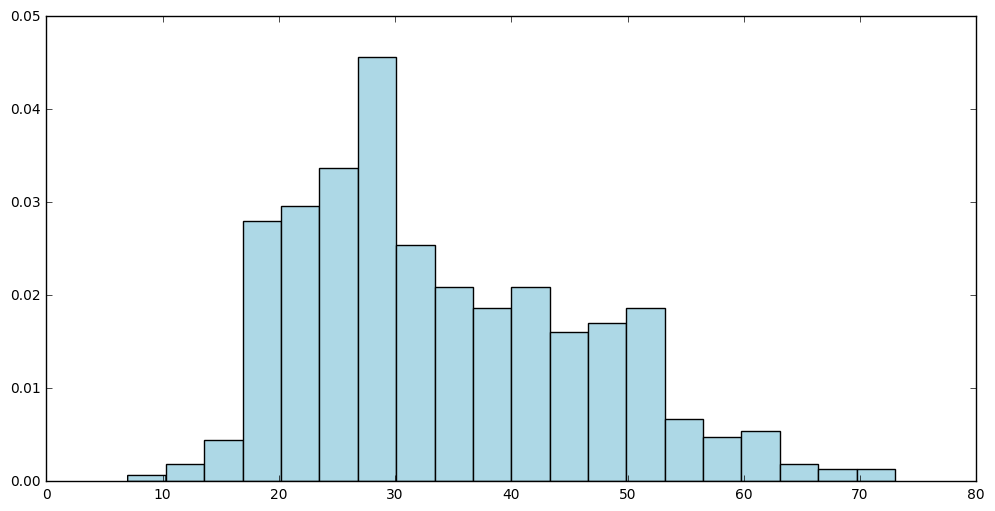

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
ages = user_fields.map(lambda x:int(x[1])).collect()
hist(ages,bins=20,color='lightblue',normed=True)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

**画出职业分布**

[(u'administrator', 79), (u'retired', 14), (u'lawyer', 12), (u'none', 9), (u'student', 196), (u'technician', 27), (u'programmer', 66), (u'salesman', 12), (u'homemaker', 7), (u'executive', 32), (u'doctor', 7), (u'entertainment', 18), (u'marketing', 26), (u'writer', 45), (u'scientist', 31), (u'educator', 95), (u'healthcare', 16), (u'librarian', 51), (u'artist', 28), (u'other', 105), (u'engineer', 67)]


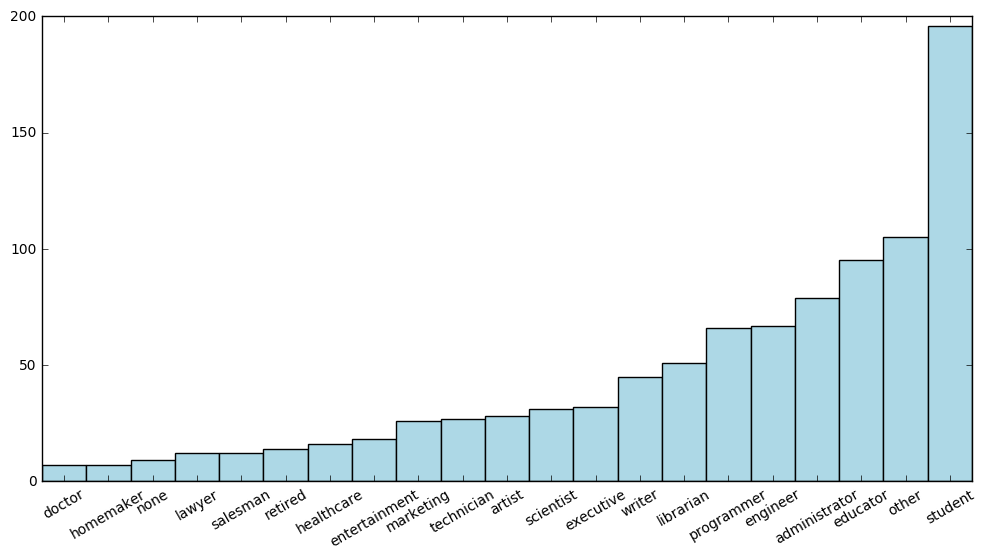

In [6]:
#画出用户的职业的分布图：

import numpy as np
count_by_occupation = user_fields.map(lambda fields: (fields[3],1)).reduceByKey(lambda x,y:x+y).collect()
print count_by_occupation
x_axis1 = np.array([c[0] for c in count_by_occupation])
y_axis1 = np.array([c[1] for c in count_by_occupation])
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]
pos = np.arange(len(x_axis))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos+(width)/2)
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis, width, color='lightblue')
plt.xticks(rotation=30)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

Spark对RDD提供了一个名为countByValue的便捷函数。它会计算RDD里各不同值所分别出现的次数,并将其以Pythondict函数的形式(或是Scala、Java下的Map函数)返回给驱动程序:

In [7]:
count_by_occupation2 = user_fields.map(lambda fields: fields[3]).countByValue()
print "Map-reduce approach:"
print dict(count_by_occupation2)
print "========================" 
print "countByValue approach:"
print dict(count_by_occupation)

Map-reduce approach:
{u'administrator': 79, u'retired': 14, u'lawyer': 12, u'healthcare': 16, u'marketing': 26, u'executive': 32, u'scientist': 31, u'student': 196, u'technician': 27, u'librarian': 51, u'programmer': 66, u'salesman': 12, u'homemaker': 7, u'engineer': 67, u'none': 9, u'doctor': 7, u'writer': 45, u'entertainment': 18, u'other': 105, u'educator': 95, u'artist': 28}
countByValue approach:
{u'administrator': 79, u'writer': 45, u'retired': 14, u'lawyer': 12, u'doctor': 7, u'marketing': 26, u'executive': 32, u'none': 9, u'entertainment': 18, u'healthcare': 16, u'scientist': 31, u'student': 196, u'educator': 95, u'technician': 27, u'librarian': 51, u'programmer': 66, u'artist': 28, u'salesman': 12, u'other': 105, u'homemaker': 7, u'engineer': 67}


##  探索电影数据

In [8]:
movie_data = sc.textFile("../../ml-100k/u.item")
print movie_data.first()
num_movies = movie_data.count()
print 'Movies: %d' %num_movies

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
Movies: 1682


绘制电影的age分布图：
绘制电影年龄的分布图的方法和之前对用户年龄和职业分布的处理类似。电影年龄即其发行年份相对于现在过了多少年(在本数据中现在是1998年)。从下面的代码可以看到,电影数据中有些数据不规整,故需要一个函数来处理解析releasedate时可能的解析错误。这里命名该函数为convert_year。

1681


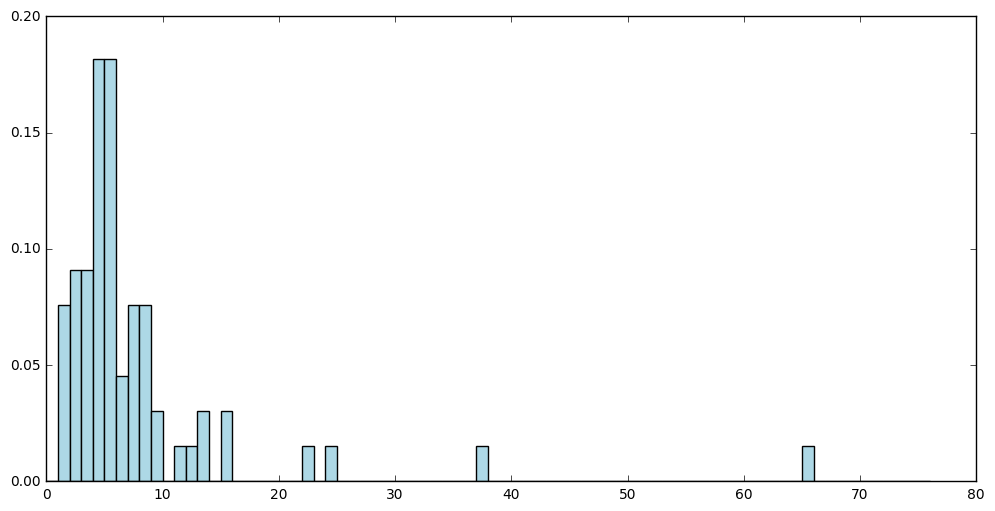

In [9]:

#画出电影的age分布图：

def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900

movie_fields = movie_data.map(lambda lines:lines.split('|'))
years = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x))
years_filtered = years.filter(lambda x: x!=1900)
print years_filtered.count()
movie_ages = years_filtered.map(lambda yr:1998-yr).countByValue()
values = movie_ages.values()
bins = movie_ages.keys()
hist(values, bins=bins, color='lightblue',normed=True)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

##  探索评分数据

In [10]:
#查看数据记录数量：

rating_data = sc.textFile("../../ml-100k/u.data")
print rating_data.first()
num_ratings = rating_data.count()
print 'Ratings: %d'% num_ratings

196	242	3	881250949
Ratings: 100000


In [11]:
#对数据进行一些基本的统计：

rating_data = rating_data.map(lambda line: line.split('\t'))
ratings = rating_data.map(lambda fields: int(fields[2]))
max_rating = ratings.reduce(lambda x,y:max(x,y))
min_rating = ratings.reduce(lambda x,y:min(x,y))
mean_rating = ratings.reduce(lambda x,y:x+y)/num_ratings
median_rating = np.median(ratings.collect())
ratings_per_user = num_ratings/num_users;
ratings_per_movie = num_ratings/ num_movies
print 'Min rating: %d' %min_rating
print 'max rating: %d' % max_rating
print 'Average rating: %2.2f' %mean_rating
print 'Median rating: %d '%median_rating
print 'Average # of ratings per user: %2.2f'%ratings_per_user
print 'Average # of ratings per movie: %2.2f' % ratings_per_movie

Min rating: 1
max rating: 5
Average rating: 3.00
Median rating: 4 
Average # of ratings per user: 106.00
Average # of ratings per movie: 59.00


In [12]:
# 同样可以使用 RDD 自带的 states() 类似统计
ratings.stats() 

(count: 100000, mean: 3.52986, stdev: 1.12566797076, max: 5.0, min: 1.0)

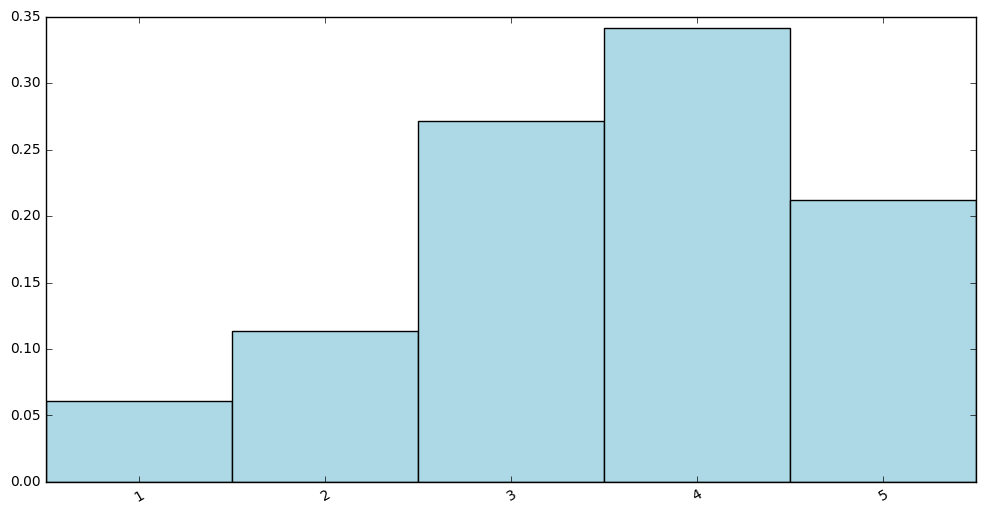

In [13]:
count_by_rating = ratings.countByValue()
x_axis = np.array(count_by_rating.keys())
y_axis = np.array([float(c) for c in count_by_rating.values()])
y_axis_normed = y_axis/y_axis.sum()
pos = np.arange(len(x_axis))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos+(width/2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [14]:
#计算每个用户和其对应的评价次数：

user_ratings_grouped = rating_data.map(lambda fields:(int(fields[0]),int(fields[2]))).groupByKey()
user_rating_byuser = user_ratings_grouped.map(lambda (k,v):(k,len(v)))
user_rating_byuser.take(5)

[(2, 62), (4, 24), (6, 211), (8, 59), (10, 184)]

绘制每个用户的总共评价次数的分布图：

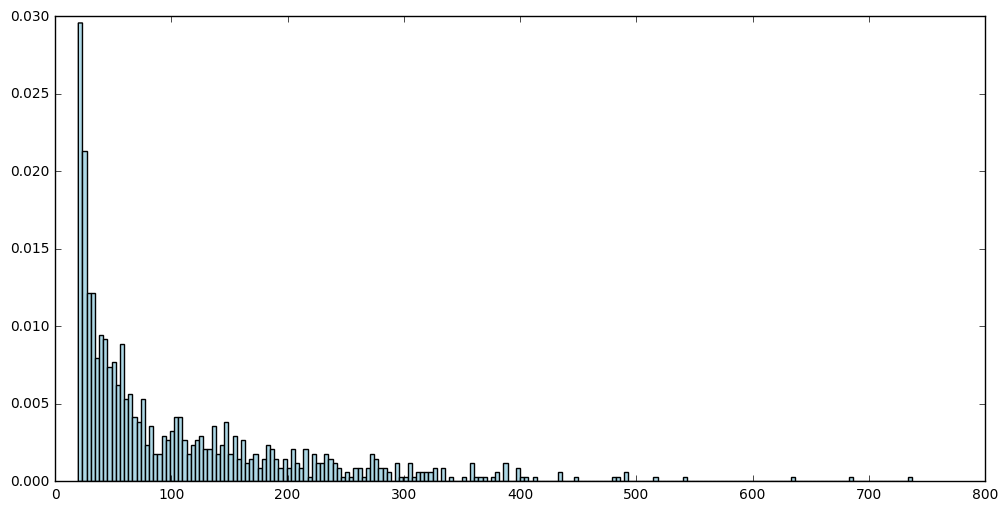

In [15]:
user_ratings_byuser_local = user_rating_byuser.map(lambda (k,v):v).collect()
hist(user_ratings_byuser_local, bins=200, color = 'lightblue',normed = True)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

计算每部电影受到的评论次数：

In [16]:
# 为每部电影计算他的被评论的次数
movie_ratings_group = rating_data.map(lambda fields: (int(fields[1]),int(fields[2]))).groupByKey()
movie_ratings_byuser = movie_ratings_group.map(lambda (k,v):(k,len(v)))
print movie_ratings_byuser.take(5)

[(2, 131), (4, 209), (6, 26), (8, 219), (10, 89)]


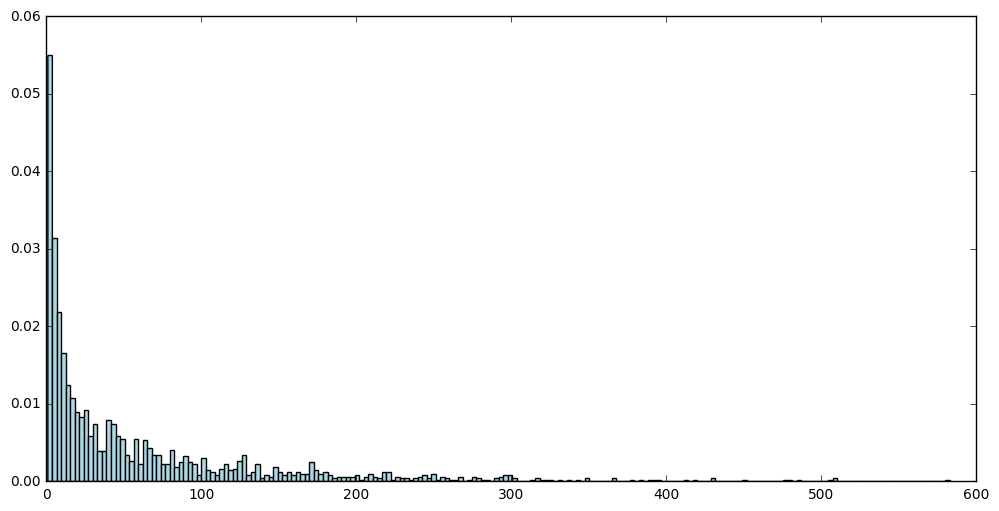

In [17]:
# 绘制电影评论次数分布图：
movie_ratings_byuser_local = movie_ratings_byuser.map(lambda (k,v):v).collect()
hist(movie_ratings_byuser_local,bins=200,color='lightblue',normed=True)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

##  数据处理与转换


##  从数据中提取有用的特征

- [数值特征(numerical feature)](#numerical):这些特征通常为实数或整数,比如之前例子中提到的年龄。
- [类别特征(categorical feature)](#categorical):它们的取值只能是可能状态集合中的某一种。我们数据集中的用户性别、职业或电影类别便是这类。
- [文本特征(text feature)](#text):它们派生自数据中的文本内容,比如电影名、描述或是评论。
- 其他特征:大部分其他特征都最终表示为数值。比如图像、视频和音频可被表示为数值数据的集合。地理位置则可由经纬度或地理散列(geohash)表示。


<h3 id="numerical">数值特征</h3>

<h3 id="categorical">类别特征</h3>

<h3 id="text">文本特征</h3>


